# Advanced geospatial plotting 

### Importing Data and Modules

In [129]:
import pandas as pd
import os
from keplergl import KeplerGl
from pyproj import CRS
import numpy as np
from matplotlib import pyplot as plt

In [130]:
df = pd.read_csv('ny_city_modified_data.csv', index_col = 0)

C:\Users\gerar\AppData\Local\Temp\ipykernel_5672\3317881836.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ny_city_modified_data.csv', index_col = 0)


In [131]:
df.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station,start_station_id,end_station,end_station_id,start_lat,start_lng,end_lat,end_lng,user_type,date,avgTemp,bike_rides_daily,_merge,value,trip_duration
81745,53194E14A1995A68,classic_bike,2022-05-22 16:13:47.172,2022-05-22 16:27:30.009,Central Park W & W 91 St,7453.01,9 Ave & W 45 St,6717.06,40.788665,-73.966801,40.760193,-73.991255,member,2022-05-22,27.8,1043,both,1,13.713950
284396,A43301F19579EE11,electric_bike,2022-12-03 13:57:21.750,2022-12-03 14:02:24.107,48 St & 50 Ave,6016.06,54 St & 37 Ave,6468.01,40.737526,-73.918007,40.750980,-73.907990,member,2022-12-03,10.6,445,both,1,5.039283
111038,70723423B96F71B0,classic_bike,2022-06-18 14:22:09.020,2022-06-18 14:29:58.509,Lenox Ave & W 111 St,7602.05,W 129 St & Convent Ave,7818.17,40.798786,-73.952300,40.814394,-73.953247,member,2022-06-18,21.7,1096,both,1,7.824817
249892,F9BB90A866D2F0D5,classic_bike,2022-10-22 20:57:26.080,2022-10-22 21:02:10.505,4 Ave & E 12 St,5788.15,Great Jones St,5636.11,40.732647,-73.990110,40.727434,-73.993790,member,2022-10-22,14.4,1141,both,1,4.740417
227830,230540566B0A61BB,classic_bike,2022-09-29 18:40:19.402,2022-09-29 18:56:30.862,W 48 St & Rockefeller Plaza,6626.11,Central Park West & W 76 St,7253.04,40.757769,-73.979294,40.778968,-73.973747,member,2022-09-29,16.6,1299,both,1,16.191000


##### Remove obsolete columns

In [133]:
df.drop(columns = ['_merge', 'value'], inplace = True)

In [134]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station',
       'start_station_id', 'end_station', 'end_station_id', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'user_type', 'date', 'avgTemp',
       'bike_rides_daily', 'trip_duration'],
      dtype='object')

## Data preprocessing

##### Create a dataframe with only the necessary columns

In [137]:
df_coordinates = df[['start_station', 'end_station', 'start_lat',
       'start_lng', 'end_lat', 'end_lng']] 
df_coordinates.head()

,start_station,end_station,start_lat,start_lng,end_lat,end_lng
0,John St & William St,Canal St & Rutgers St,40.708621,-74.007222,40.714275,-73.989900
1,Adelphi St & Myrtle Ave,Dean St & Franklin Ave,40.693083,-73.971789,40.677592,-73.955637
2,W 15 St & 6 Ave,E 7 St & Avenue A,40.738046,-73.996430,40.726218,-73.983799
3,Carmine St & 6 Ave,Washington Pl & 6 Ave,40.730386,-74.002150,40.732241,-74.000264
4,Greenwich St & Perry St,Greenwich St & W Houston St,40.734980,-74.006970,40.728846,-74.008591


In [138]:
# drop duplicates on df_coordinates based off start_station and end_station. Only one combination possible. Removes duplicate coordinates.  
df_coordinates = df_coordinates.drop_duplicates(subset = ['start_station', 'end_station'], keep='first', inplace=False, ignore_index=True)
df_coordinates.sample(10)

,start_station,end_station,start_lat,start_lng,end_lat,end_lng
53061,31 St & Newtown Ave,27 Ave & 3 St,40.767549,-73.920933,40.774850,-73.934200
121199,Ft. Hamilton Pkwy & E 2 St,Church Ave & Story St,40.648030,-73.979423,40.642031,-73.981073
68026,India St & Manhattan Ave,48 St & 37 Ave,40.732322,-73.955086,40.751555,-73.915026
60012,Central Park W & W 91 St,11 Ave & W 59 St,40.788665,-73.966801,40.771497,-73.990460
146286,Broadway & E 19 St,Forsyth St & Grand St,40.738661,-73.989873,40.717798,-73.993161
68635,Central Park North & Adam Clayton Powell Blvd,2 Ave & E 99 St,40.799484,-73.955613,40.786259,-73.945526
126620,Lexington Ave & E 29 St,E 41 St & Madison Ave (SW corner),40.743116,-73.982154,40.752165,-73.979922
84232,6 Ave & Canal St,Walker St & Baxter St,40.722438,-74.005664,40.717411,-73.999573
61130,W 39 St & 9 Ave,Little West St & 1 Pl,40.756458,-73.993722,40.705693,-74.016777
18718,Reade St & Broadway,Bus Slip & State St,40.714505,-74.005628,40.701907,-74.013942


In [139]:
# Create a value column and group by start and end station. This value can be anything, a number or string.
# It is simply a placeholder

df['value'] = 1
df_group = df.groupby(['start_station', 'end_station'])['value'].count().reset_index()


In [140]:
df_group

,start_station,end_station,value
0,1 Ave & E 110 St,1 Ave & E 110 St,8
1,1 Ave & E 110 St,1 Ave & E 62 St,1
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2
...,...,...,...
149391,Yankee Ferry Terminal,Broad St & Bridge St,1
149392,Yankee Ferry Terminal,Court St & Nelson St,1
149393,Yankee Ferry Terminal,Picnic Point,34
149394,Yankee Ferry Terminal,Soissons Landing,49


In [141]:
# Rename value column for a more intuitive name

df_group.rename(columns = {'value' : 'station_pair_trip_count'}, inplace = True)
df_group

,start_station,end_station,station_pair_trip_count
0,1 Ave & E 110 St,1 Ave & E 110 St,8
1,1 Ave & E 110 St,1 Ave & E 62 St,1
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2
...,...,...,...
149391,Yankee Ferry Terminal,Broad St & Bridge St,1
149392,Yankee Ferry Terminal,Court St & Nelson St,1
149393,Yankee Ferry Terminal,Picnic Point,34
149394,Yankee Ferry Terminal,Soissons Landing,49


In [142]:
df_merged = pd.merge(df_coordinates, df_group, on = ['start_station', 'end_station'], how='inner', indicator = True)
df_merged.sample(5)

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count,_merge
104288,Bushwick Ave & McKibbin St,Front St & Gold St,40.705640,-73.939366,40.702240,-73.982578,1,both
123888,Orchard St & Grand St,Lafayette St & E 8 St,40.717374,-73.990406,40.730207,-73.991026,2,both
61479,Clark St & Henry St,Wyckoff Av & Jefferson St,40.697601,-73.993446,40.707165,-73.923711,1,both
8607,2 Ave & E 72 St,E 74 St & 1 Ave,40.768762,-73.958408,40.768974,-73.954823,11,both
96574,W 64 St & Thelonious Monk Circle,Christopher St & Greenwich St,40.775160,-73.989187,40.732916,-74.007114,1,both


In [143]:
# Sort dataframe to get only the top 150 trips based off the station_pair_trip_count (reset to new index) 
df_top_150 = df_merged.nlargest(n = 150, columns = 'station_pair_trip_count').reset_index(drop = True)
df_top_150

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count,_merge
0,Central Park S & 6 Ave,Central Park S & 6 Ave,40.765909,-73.976342,40.765909,-73.976342,110,both
1,7 Ave & Central Park South,7 Ave & Central Park South,40.766741,-73.979069,40.766741,-73.979069,73,both
2,Roosevelt Island Tramway,Roosevelt Island Tramway,40.757284,-73.953600,40.757284,-73.953600,73,both
3,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,40.764397,-73.973715,40.764397,-73.973715,71,both
4,W 21 St & 6 Ave,9 Ave & W 22 St,40.741740,-73.994156,40.745497,-74.001971,64,both
...,...,...,...,...,...,...,...,...
145,West St & Liberty St,West St & Chambers St,40.711444,-74.014847,40.717548,-74.013221,26,both
146,Vernon Blvd & 50 Ave,46 Ave & 5 St,40.742327,-73.954117,40.747310,-73.954510,26,both
147,10 Ave & W 14 St,West St & Liberty St,40.741982,-74.008316,40.711444,-74.014847,26,both
148,Central Park S & 6 Ave,5 Ave & E 72 St,40.765909,-73.976342,40.772828,-73.966853,26,both


In [144]:
# Checking shape of dataframe
print(df_top_150['station_pair_trip_count'].sum())
print(df.shape)

5353
(297971, 18)


In [145]:
# Perform basic EDA of df_group
df_top_150['station_pair_trip_count'].describe()

count    150.000000
mean      35.686667
std       12.333257
min       26.000000
25%       27.000000
50%       30.000000
75%       40.000000
max      110.000000
Name: station_pair_trip_count, dtype: float64

### Exploratory Analysis Charts

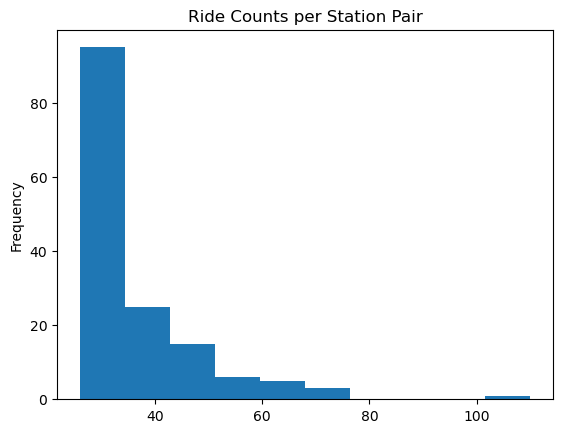

In [147]:
hist_plot_ride_counts = df_top_150['station_pair_trip_count'].plot(kind = 'hist', bins = 10, title = 'Ride Counts per Station Pair')

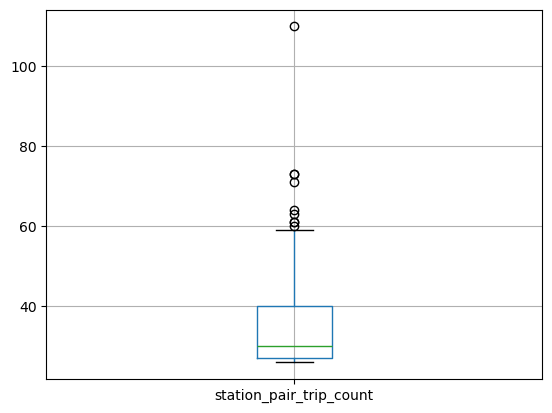

In [148]:
box_plot_ride_counts = df_top_150.boxplot(column = 'station_pair_trip_count') 

In [149]:
# remove obsolete columns

df_top_150.drop(columns = '_merge', inplace = True)

In [150]:
df_top_150.sample(5)

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count
57,E 72 St & York Ave,2 Ave & E 72 St,40.766638,-73.953483,40.768762,-73.958408,34
20,Central Park West & W 72 St,Central Park West & W 72 St,40.775794,-73.976206,40.775794,-73.976206,46
24,West St & Chambers St,10 Ave & W 14 St,40.717548,-74.013221,40.741982,-74.008316,45
149,W 21 St & 6 Ave,6 Ave & W 33 St,40.741740,-73.994156,40.749013,-73.988484,26
29,Central Park North & Adam Clayton Powell Blvd,Central Park North & Adam Clayton Powell Blvd,40.799484,-73.955613,40.799484,-73.955613,44


In [151]:
# Use garbage collector to improve code performance
import gc 
gc.collect()

5827

## Plot the map

In [153]:
# is this really neccesary? exporting this dataset. Can we discuss this during the call? 
# df_final.to_csv('df_final_locations_for_map.csv')

In [154]:
df_top_150.to_csv('top_150_trips.csv', index = False)

In [155]:
df_top_150.head()

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count
0,Central Park S & 6 Ave,Central Park S & 6 Ave,40.765909,-73.976342,40.765909,-73.976342,110
1,7 Ave & Central Park South,7 Ave & Central Park South,40.766741,-73.979069,40.766741,-73.979069,73
2,Roosevelt Island Tramway,Roosevelt Island Tramway,40.757284,-73.953600,40.757284,-73.953600,73
3,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,40.764397,-73.973715,40.764397,-73.973715,71
4,W 21 St & 6 Ave,9 Ave & W 22 St,40.741740,-73.994156,40.745497,-74.001971,64


In [156]:
# Create KeplerGl instance

# m = KeplerGl(height = 700, data={"data_1": df_merged})
# m

In [157]:
# config = m.config

In [158]:
# config

In [159]:
# import json
# with open("config.json", "w") as outfile:
#    json.dump(config, outfile)